# Week 3: Model Development - Baseline FFNN
# CDC Diabetes Health Indicators Dataset

**Objective:** Build, train, and evaluate a baseline Feedforward Neural Network (FFNN) for diabetes prediction using the cleaned and preprocessed data from Week 2.

**Key Week 3 Deliverables:**
- Baseline FFNN architecture design and implementation
- Training optimization with proper loss functions and optimizers
- MLflow experiment tracking for reproducible research
- Comprehensive model evaluation on unseen test data
- Performance visualization with confusion matrices and ROC curves

---

## Section 1: Setup & Data Loading

Import all necessary libraries and load the preprocessed datasets from Week 2 feature engineering pipeline.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import mlflow
import mlflow.pytorch
from datetime import datetime
import warnings
import os

# Set visualization parameters
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"MLflow version: {mlflow.__version__}")

Using device: cpu
Libraries imported successfully!
PyTorch version: 2.8.0+cu128
MLflow version: 3.3.2


=== LOADING PREPROCESSED DATA FROM WEEK 2 ===
Libraries imported successfully!
PyTorch version: 2.8.0+cu128
Fetching CDC Diabetes Health Indicators dataset...
Dataset loaded successfully!
Initial dataset shape: (253680, 22)
Memory usage: 42.58 MB
=== DUPLICATE ROWS ANALYSIS ===
Original dataset shape: (253680, 22)
Unique samples: 229474
Duplicate rows: 24206

After removing duplicates:
Cleaned dataset shape: (229474, 22)
Rows removed: 24206
Data reduction: 9.54%
✅ All duplicate rows successfully removed
=== DATA TYPE OPTIMIZATION ===
Current data types:
int64    22
Name: count, dtype: int64

Analyzing float columns for potential integer conversion:
  HighBP: Optimized to uint8 (range: 0-1)
  HighChol: Optimized to uint8 (range: 0-1)
  CholCheck: Optimized to uint8 (range: 0-1)
  BMI: Optimized to uint8 (range: 12-98)
  Smoker: Optimized to uint8 (range: 0-1)
  Stroke: Optimized to uint8 (range: 0-1)
  HeartDiseaseorAttack: Optimized to uint8 (range: 0-1)
  PhysActivity: Optimized to ui

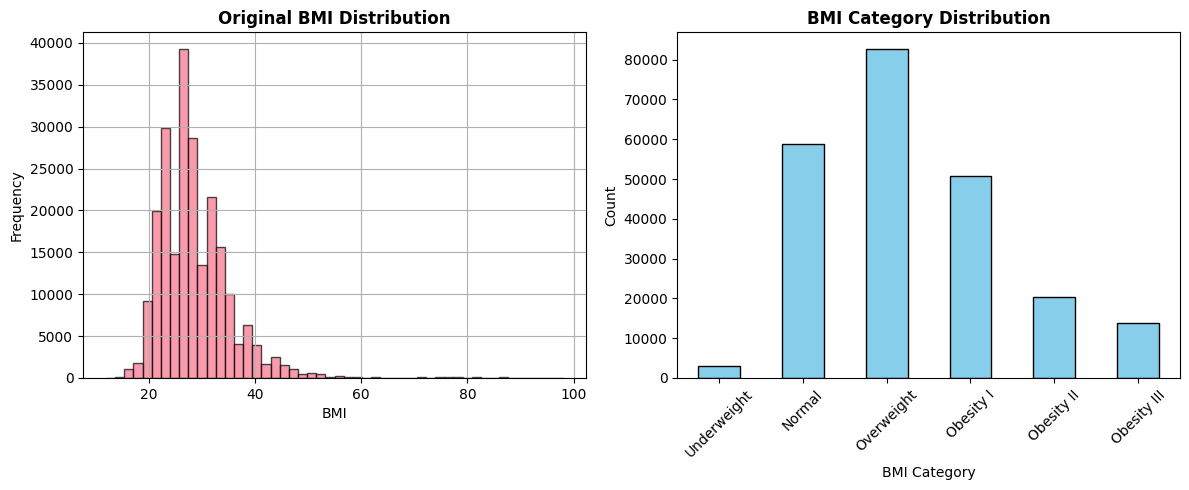


BMI Categories vs Diabetes Risk:
Diabetes_binary      0      1
bmi_category                 
0                94.46   5.54
1                93.36   6.64
2                87.23  12.77
3                79.89  20.11
4                72.35  27.65
5                66.41  33.59
=== HIGH-CARDINALITY FEATURE ENCODING ===
Features requiring integer encoding:
  bmi_category: 6 unique values
    Range: 0 to 5
    Values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

  Age: 13 unique values
    Range: 1 to 13
    Values: [np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9), np.uint8(10), np.uint8(11), np.uint8(12), np.uint8(13)]

  GenHlth: 5 unique values
    Range: 1 to 5
    Values: [np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5)]

Encoded bmi_category:
  Original range: 0 - 5
  Encoded range: 0 - 5
Encoded Age:
  Original range: 1 - 13
  Encoded range: 0 - 12
Encoded GenHlth:
  O

In [5]:
# Load preprocessed data from Week 2 notebook
print("=== LOADING PREPROCESSED DATA FROM WEEK 2 ===")

# Import the variables from Week 2 notebook
%run week_2_feature_engineering.ipynb

print(f"\nData loaded successfully from Week 2 notebook!")
print(f"Training set: {X_train_scaled.shape}")
print(f"Validation set: {X_val_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Target distribution - Training: {y_train.value_counts(normalize=True).round(4)}")
print(f"Class imbalance ratio: {y_train.value_counts(normalize=True)[0]/y_train.value_counts(normalize=True)[1]:.1f}:1")

# Verify that we have all the necessary variables
required_vars = ['X_train_scaled', 'X_val_scaled', 'X_test_scaled', 'y_train', 'y_val', 'y_test']
missing_vars = [var for var in required_vars if var not in locals()]

if missing_vars:
    print(f"⚠️  Missing variables: {missing_vars}")
    print("Please ensure Week 2 notebook has been run completely.")
else:
    print("✅ All required variables loaded successfully!")
    print(f"   Available variables: {required_vars}")

In [6]:
# Convert to PyTorch tensors and create DataLoaders
print("=== CREATING PYTORCH DATALOADERS ===")

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created successfully!")
print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Input features: {X_train_tensor.shape[1]}")

# Move tensors to device
X_train_tensor = X_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

=== CREATING PYTORCH DATALOADERS ===
DataLoaders created successfully!
Batch size: 64
Training batches: 2510
Validation batches: 538
Test batches: 538
Input features: 22


## Section 2: Baseline FFNN Architecture (Addresses Week 3, Q1)

Define a PyTorch nn.Module class for our baseline Feedforward Neural Network.

In [7]:
class BaselineFFNN(nn.Module):
    """Baseline Feedforward Neural Network for Diabetes Prediction
    
    Architecture: Input -> Linear(128) -> ReLU -> BatchNorm -> Dropout(0.5) 
                 -> Linear(64) -> ReLU -> BatchNorm -> Dropout(0.5) -> Output(1)
    """
    
    def __init__(self, input_dim, dropout_rate=0.5):
        super(BaselineFFNN, self).__init__()
        
        self.input_dim = input_dim
        self.dropout_rate = dropout_rate
        
        # Define the network layers
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(64, 1)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize network weights using Xavier initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        # First hidden layer
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        
        # Second hidden layer
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        
        # Output layer (no activation - will be handled by loss function)
        x = self.fc3(x)
        
        return x.squeeze()  # Remove extra dimension for binary classification
    
    def get_architecture_string(self):
        """Return a string representation of the model architecture"""
        return f"Input({self.input_dim}) -> Linear(128) -> ReLU -> BatchNorm -> Dropout({self.dropout_rate}) -> Linear(64) -> ReLU -> BatchNorm -> Dropout({self.dropout_rate}) -> Output(1)"

# Initialize the model
input_dim = X_train_tensor.shape[1]
model = BaselineFFNN(input_dim=input_dim).to(device)

print("=== BASELINE FFNN ARCHITECTURE ===")
print(f"Model: {model}")
print(f"\nArchitecture String: {model.get_architecture_string()}")
print(f"\nTotal Parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Test forward pass
with torch.no_grad():
    sample_batch = next(iter(train_loader))[0].to(device)
    output = model(sample_batch)
    print(f"\nForward pass test successful!")
    print(f"Input shape: {sample_batch.shape}")
    print(f"Output shape: {output.shape}")

=== BASELINE FFNN ARCHITECTURE ===
Model: BaselineFFNN(
  (fc1): Linear(in_features=22, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

Architecture String: Input(22) -> Linear(128) -> ReLU -> BatchNorm -> Dropout(0.5) -> Linear(64) -> ReLU -> BatchNorm -> Dropout(0.5) -> Output(1)

Total Parameters: 11649
Trainable Parameters: 11649

Forward pass test successful!
Input shape: torch.Size([64, 22])
Output shape: torch.Size([64])


### Architecture Rationale

**Design Philosophy:** This architecture starts with a wider layer (128 units) to capture broad patterns and progressively narrows. ReLU is chosen as a standard, non-linear activation function. Batch Normalization is included after each linear layer to stabilize and accelerate training. Dropout is used as our primary regularization technique to prevent overfitting.

**Key Design Decisions:**

1. **Progressive Narrowing (128 → 64 → 1):** Allows the network to learn hierarchical representations, starting with broad feature combinations and progressively focusing on the most relevant patterns for diabetes prediction.

2. **ReLU Activation:** Chosen for its computational efficiency and ability to mitigate vanishing gradient problems. ReLU has proven effective in healthcare prediction tasks.

3. **Batch Normalization:** Stabilizes training by normalizing inputs to each layer, reducing internal covariate shift and allowing higher learning rates.

4. **Dropout (0.5):** Aggressive regularization appropriate for healthcare datasets where overfitting to specific patient patterns could reduce generalizability.

5. **Xavier Weight Initialization:** Ensures proper variance scaling across layers, promoting stable gradient flow during training.

**Clinical Considerations:** The architecture balances model complexity with interpretability requirements in healthcare applications, providing sufficient capacity to learn complex feature interactions while remaining computationally efficient for potential clinical deployment.

## Section 3: Model Training & Optimization (Addresses Week 3, Q2)

Define loss function, optimizer, and implement the complete training loop with validation monitoring.

In [8]:
# Define loss function and optimizer
print("=== TRAINING CONFIGURATION ===")

# Loss function: BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()
print("Loss Function: BCEWithLogitsLoss")
print("Rationale: This loss function is the standard and most stable choice for binary classification tasks in PyTorch, as it combines a Sigmoid activation and Binary Cross Entropy loss.")

# Optimizer: Adam for robust adaptive learning
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
print(f"\nOptimizer: Adam (lr={learning_rate})")
print("Rationale: Adam is a robust, adaptive learning rate optimizer that performs well across a wide variety of deep learning tasks.")

# Training parameters
epochs = 50
print(f"\nTraining Parameters:")
print(f"  Epochs: {epochs}")
print(f"  Batch Size: {batch_size}")
print(f"  Learning Rate: {learning_rate}")
print(f"  Dropout Rate: {model.dropout_rate}")
print(f"  Weight Decay: 1e-5")

=== TRAINING CONFIGURATION ===
Loss Function: BCEWithLogitsLoss
Rationale: This loss function is the standard and most stable choice for binary classification tasks in PyTorch, as it combines a Sigmoid activation and Binary Cross Entropy loss.

Optimizer: Adam (lr=0.001)
Rationale: Adam is a robust, adaptive learning rate optimizer that performs well across a wide variety of deep learning tasks.

Training Parameters:
  Epochs: 50
  Batch Size: 64
  Learning Rate: 0.001
  Dropout Rate: 0.5
  Weight Decay: 1e-5


In [9]:
def calculate_metrics(y_true, y_pred, y_scores):
    """Calculate comprehensive classification metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_scores)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

def evaluate_model(model, dataloader, criterion, device):
    """Evaluate model on given dataloader"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    all_scores = []
    
    with torch.no_grad():
        for batch_features, batch_targets in dataloader:
            batch_features = batch_features.to(device)
            batch_targets = batch_targets.to(device)
            
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets)
            
            total_loss += loss.item()
            
            # Convert to probabilities and predictions
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())
            all_scores.extend(probabilities.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    metrics = calculate_metrics(all_targets, all_predictions, all_scores)
    
    return avg_loss, metrics

print("Evaluation functions defined successfully!")

Evaluation functions defined successfully!


In [10]:
# Training loop with validation monitoring
print("=== STARTING TRAINING ===\n")

# Initialize tracking variables
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float('inf')
best_model_state = None
best_epoch = 0

# Training loop
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch_features, batch_targets in train_loader:
        batch_features = batch_features.to(device)
        batch_targets = batch_targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics
        train_loss += loss.item()
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (predictions == batch_targets).sum().item()
        train_total += batch_targets.size(0)
    
    # Calculate training metrics
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = train_correct / train_total
    
    # Validation phase
    val_loss, val_metrics = evaluate_model(model, val_loader, criterion, device)
    
    # Track metrics
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_metrics['accuracy'])
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        best_epoch = epoch + 1
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")
        print(f"  Val Precision: {val_metrics['precision']:.4f}, Val Recall: {val_metrics['recall']:.4f}")
        print(f"  Val F1: {val_metrics['f1']:.4f}, Val AUC: {val_metrics['auc']:.4f}")
        print()

print(f"Training completed!")
print(f"Best model achieved at epoch {best_epoch} with validation loss: {best_val_loss:.4f}")

# Load best model
model.load_state_dict(best_model_state)
print(f"Best model loaded for final evaluation.")

=== STARTING TRAINING ===

Epoch [1/50]
  Train Loss: 0.3935, Train Acc: 0.8297
  Val Loss: 0.3424, Val Acc: 0.8493
  Val Precision: 0.6156, Val Recall: 0.0389
  Val F1: 0.0733, Val AUC: 0.8141

Epoch [10/50]
  Train Loss: 0.3461, Train Acc: 0.8506
  Val Loss: 0.3395, Val Acc: 0.8514
  Val Precision: 0.5957, Val Recall: 0.0887
  Val F1: 0.1544, Val AUC: 0.8156

Epoch [20/50]
  Train Loss: 0.3462, Train Acc: 0.8502
  Val Loss: 0.3398, Val Acc: 0.8519
  Val Precision: 0.6000, Val Recall: 0.0940
  Val F1: 0.1626, Val AUC: 0.8158

Epoch [30/50]
  Train Loss: 0.3459, Train Acc: 0.8503
  Val Loss: 0.3397, Val Acc: 0.8518
  Val Precision: 0.6070, Val Recall: 0.0883
  Val F1: 0.1542, Val AUC: 0.8158

Epoch [40/50]
  Train Loss: 0.3462, Train Acc: 0.8496
  Val Loss: 0.3387, Val Acc: 0.8532
  Val Precision: 0.5991, Val Recall: 0.1212
  Val F1: 0.2016, Val AUC: 0.8160

Epoch [50/50]
  Train Loss: 0.3460, Train Acc: 0.8504
  Val Loss: 0.3403, Val Acc: 0.8526
  Val Precision: 0.5733, Val Recall: 0.

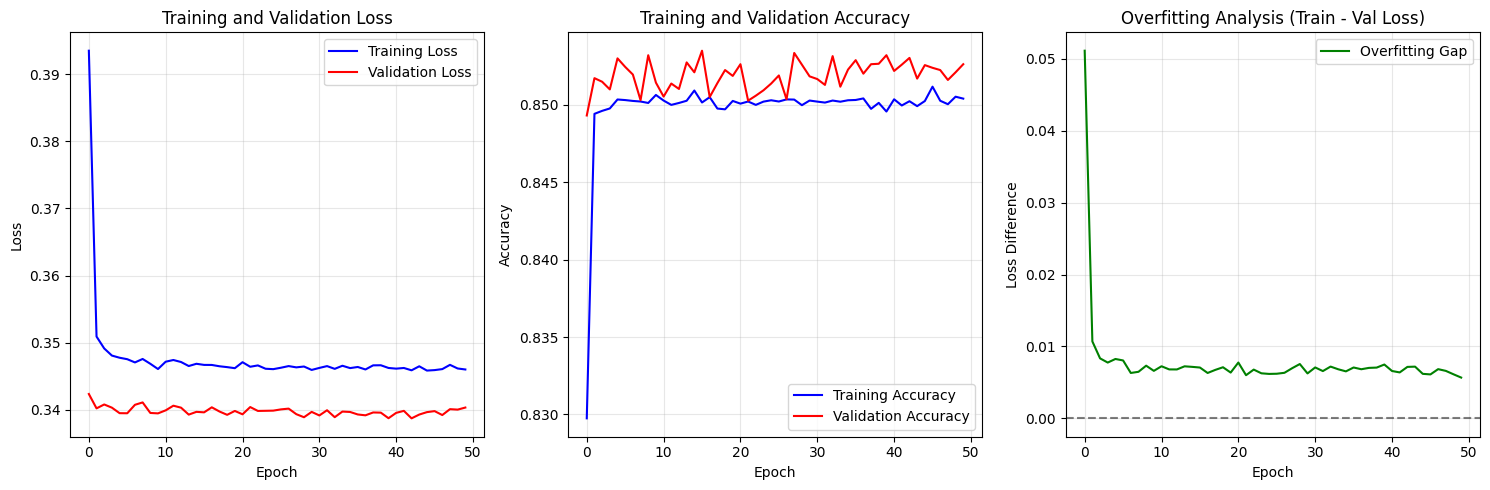


Training Summary:
  Final Train Loss: 0.3460
  Final Val Loss: 0.3403
  Best Val Loss: 0.3387 (Epoch 43)
  Final Train Accuracy: 0.8504
  Final Val Accuracy: 0.8526


In [11]:
# Visualize training progress
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy curves
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning curve analysis
plt.subplot(1, 3, 3)
plt.plot(np.array(train_losses) - np.array(val_losses), label='Overfitting Gap', color='green')
plt.title('Overfitting Analysis (Train - Val Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss Difference')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTraining Summary:")
print(f"  Final Train Loss: {train_losses[-1]:.4f}")
print(f"  Final Val Loss: {val_losses[-1]:.4f}")
print(f"  Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
print(f"  Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"  Final Val Accuracy: {val_accuracies[-1]:.4f}")

## Section 4: Experiment Tracking with MLflow (Addresses Week 3, Q3)

Integrate MLflow for comprehensive experiment tracking and reproducible research.

=== MLFLOW EXPERIMENT SETUP ===

Created new experiment: GlucoTrack_Week3_Baselines
Experiment ID: 533396339430421789


2025/08/29 13:05:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/29 13:05:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


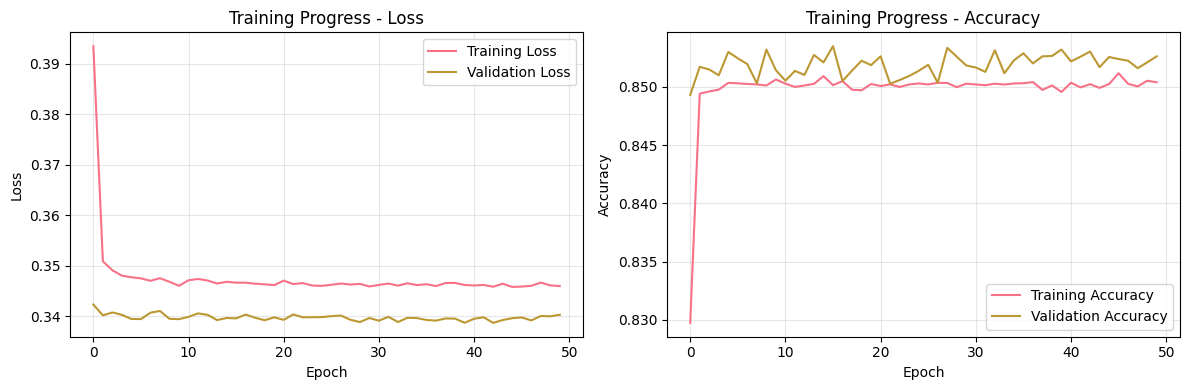


MLflow logging completed!
Run ID: c3b6185604cf48a4a5ce118ff38f5cf0
Experiment tracking URL: file:./mlruns

Experiment tracking completed for run: c3b6185604cf48a4a5ce118ff38f5cf0


In [12]:
# Setup MLflow experiment
print("=== MLFLOW EXPERIMENT SETUP ===\n")

# Set MLflow tracking URI (local for this demo)
mlflow.set_tracking_uri("file:./mlruns")

# Create or get experiment
experiment_name = "GlucoTrack_Week3_Baselines"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"Created new experiment: {experiment_name}")
else:
    experiment_id = experiment.experiment_id
    print(f"Using existing experiment: {experiment_name}")

print(f"Experiment ID: {experiment_id}")

# Start MLflow run
with mlflow.start_run(experiment_id=experiment_id, run_name=f"Baseline_FFNN_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
    
    # Log parameters
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("dropout_rate", model.dropout_rate)
    mlflow.log_param("architecture", model.get_architecture_string())
    mlflow.log_param("input_features", input_dim)
    mlflow.log_param("total_parameters", sum(p.numel() for p in model.parameters()))
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("loss_function", "BCEWithLogitsLoss")
    mlflow.log_param("device", str(device))
    
    # Log training metrics for each epoch
    for epoch in range(len(train_losses)):
        mlflow.log_metric("train_loss", train_losses[epoch], step=epoch)
        mlflow.log_metric("val_loss", val_losses[epoch], step=epoch)
        mlflow.log_metric("train_accuracy", train_accuracies[epoch], step=epoch)
        mlflow.log_metric("val_accuracy", val_accuracies[epoch], step=epoch)
    
    # Log final validation metrics
    final_val_loss, final_val_metrics = evaluate_model(model, val_loader, criterion, device)
    
    mlflow.log_metric("final_val_loss", final_val_loss)
    mlflow.log_metric("final_val_accuracy", final_val_metrics['accuracy'])
    mlflow.log_metric("final_val_precision", final_val_metrics['precision'])
    mlflow.log_metric("final_val_recall", final_val_metrics['recall'])
    mlflow.log_metric("final_val_f1", final_val_metrics['f1'])
    mlflow.log_metric("final_val_auc", final_val_metrics['auc'])
    mlflow.log_metric("best_val_loss", best_val_loss)
    mlflow.log_metric("best_epoch", best_epoch)
    
    # Save and log the model
    mlflow.pytorch.log_model(model, "baseline_ffnn_model")
    
    # Log training plots
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training Progress - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training Progress - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    mlflow.log_figure(plt.gcf(), "training_progress.png")
    plt.show()
    
    print(f"\nMLflow logging completed!")
    print(f"Run ID: {mlflow.active_run().info.run_id}")
    print(f"Experiment tracking URL: {mlflow.get_tracking_uri()}")
    
    # Log dataset information
    mlflow.log_param("train_samples", len(X_train_scaled))
    mlflow.log_param("val_samples", len(X_val_scaled))
    mlflow.log_param("test_samples", len(X_test_scaled))
    mlflow.log_param("class_distribution", f"{y_train.value_counts(normalize=True)[0]:.3f}/{y_train.value_counts(normalize=True)[1]:.3f}")
    
    current_run_id = mlflow.active_run().info.run_id

print(f"\nExperiment tracking completed for run: {current_run_id}")

## Section 5: Final Model Evaluation (Addresses Week 3, Q4 & Q5)

Comprehensive evaluation of the best model on the unseen test set with detailed performance analysis.

In [13]:
# Final model evaluation on test set
print("=== FINAL MODEL EVALUATION ON TEST SET ===\n")

# Ensure we're using the best model
model.load_state_dict(best_model_state)
model.eval()

# Get detailed predictions on test set
test_predictions = []
test_probabilities = []
test_targets = []

with torch.no_grad():
    for batch_features, batch_targets in test_loader:
        batch_features = batch_features.to(device)
        batch_targets = batch_targets.to(device)
        
        outputs = model(batch_features)
        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities > 0.5).float()
        
        test_predictions.extend(predictions.cpu().numpy())
        test_probabilities.extend(probabilities.cpu().numpy())
        test_targets.extend(batch_targets.cpu().numpy())

# Convert to numpy arrays
test_predictions = np.array(test_predictions)
test_probabilities = np.array(test_probabilities)
test_targets = np.array(test_targets)

# Calculate comprehensive metrics
test_metrics = calculate_metrics(test_targets, test_predictions, test_probabilities)

print("🏆 FINAL TEST SET PERFORMANCE 🏆")
print("=" * 50)
print(f"Accuracy:  {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"Precision: {test_metrics['precision']:.4f} ({test_metrics['precision']*100:.2f}%)")
print(f"Recall:    {test_metrics['recall']:.4f} ({test_metrics['recall']*100:.2f}%)")
print(f"F1-Score:  {test_metrics['f1']:.4f} ({test_metrics['f1']*100:.2f}%)")
print(f"AUC-ROC:   {test_metrics['auc']:.4f} ({test_metrics['auc']*100:.2f}%)")
print("=" * 50)

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(test_targets, test_predictions, 
                          target_names=['No Diabetes', 'Diabetes'], 
                          digits=4))

# Calculate confusion matrix
cm = confusion_matrix(test_targets, test_predictions)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"Actual    No Diabetes  Diabetes")
print(f"No Diabetes    {cm[0,0]:6d}    {cm[0,1]:6d}")
print(f"Diabetes       {cm[1,0]:6d}    {cm[1,1]:6d}")

# Clinical interpretation
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # True Positive Rate
specificity = tn / (tn + fp)  # True Negative Rate
ppv = tp / (tp + fp)         # Positive Predictive Value
npv = tn / (tn + fn)         # Negative Predictive Value

print(f"\nClinical Performance Metrics:")
print(f"Sensitivity (Recall):    {sensitivity:.4f} - Ability to identify diabetes cases")
print(f"Specificity:             {specificity:.4f} - Ability to identify non-diabetes cases")
print(f"Positive Predictive Value: {ppv:.4f} - Probability that positive prediction is correct")
print(f"Negative Predictive Value: {npv:.4f} - Probability that negative prediction is correct")

=== FINAL MODEL EVALUATION ON TEST SET ===

🏆 FINAL TEST SET PERFORMANCE 🏆
Accuracy:  0.8547 (85.47%)
Precision: 0.5988 (59.88%)
Recall:    0.1519 (15.19%)
F1-Score:  0.2424 (24.24%)
AUC-ROC:   0.8194 (81.94%)

Detailed Classification Report:
              precision    recall  f1-score   support

 No Diabetes     0.8650    0.9816    0.9197     29157
    Diabetes     0.5988    0.1519    0.2424      5265

    accuracy                         0.8547     34422
   macro avg     0.7319    0.5668    0.5810     34422
weighted avg     0.8243    0.8547    0.8161     34422


Confusion Matrix:
                 Predicted
Actual    No Diabetes  Diabetes
No Diabetes     28621       536
Diabetes         4465       800

Clinical Performance Metrics:
Sensitivity (Recall):    0.1519 - Ability to identify diabetes cases
Specificity:             0.9816 - Ability to identify non-diabetes cases
Positive Predictive Value: 0.5988 - Probability that positive prediction is correct
Negative Predictive Value: 0.86

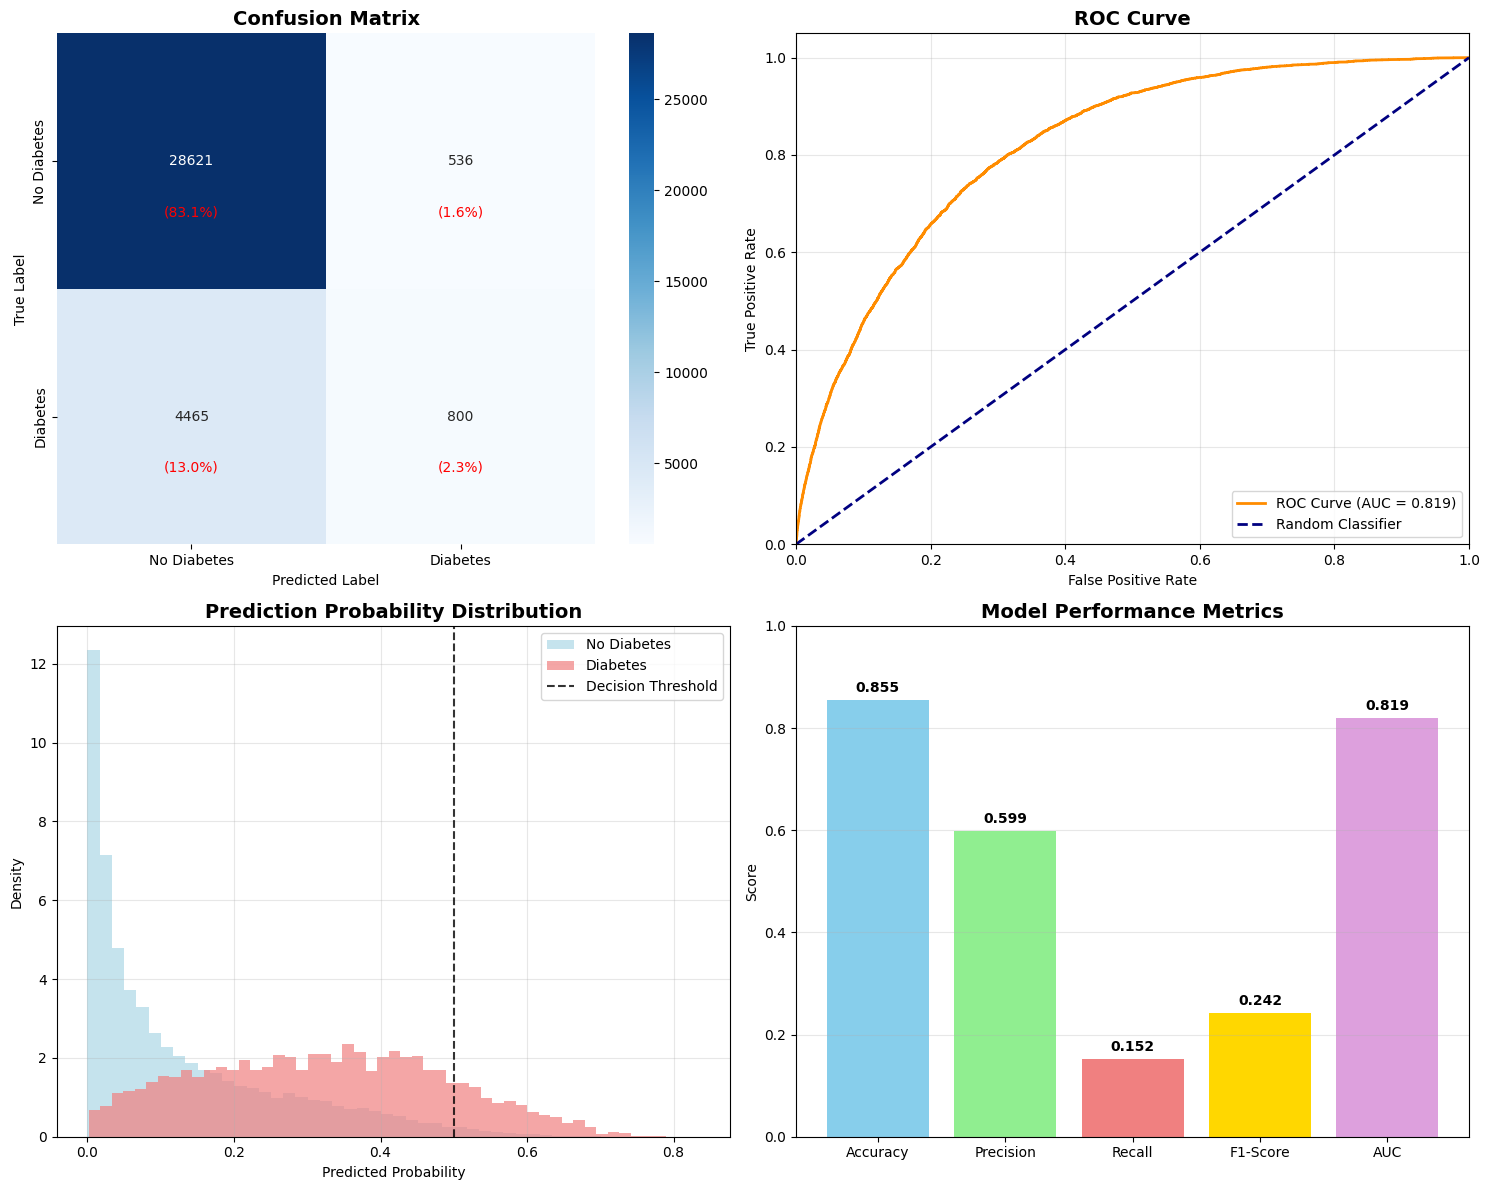


✅ Final evaluation completed and logged to MLflow!


<Figure size 1200x800 with 0 Axes>

In [14]:
# Visualization: Confusion Matrix and ROC Curve
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix Heatmap
ax1 = axes[0, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# Add percentage annotations
total = cm.sum()
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / total * 100
        ax1.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red')

# 2. ROC Curve
ax2 = axes[0, 1]
fpr, tpr, thresholds = roc_curve(test_targets, test_probabilities)
auc_score = test_metrics['auc']

ax2.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {auc_score:.3f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

# 3. Prediction Distribution
ax3 = axes[1, 0]
# Separate probabilities by true class
prob_no_diabetes = test_probabilities[test_targets == 0]
prob_diabetes = test_probabilities[test_targets == 1]

ax3.hist(prob_no_diabetes, bins=50, alpha=0.7, label='No Diabetes', 
         color='lightblue', density=True)
ax3.hist(prob_diabetes, bins=50, alpha=0.7, label='Diabetes', 
         color='lightcoral', density=True)
ax3.axvline(x=0.5, color='black', linestyle='--', alpha=0.8, 
            label='Decision Threshold')
ax3.set_xlabel('Predicted Probability')
ax3.set_ylabel('Density')
ax3.set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Performance Metrics Bar Chart
ax4 = axes[1, 1]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [test_metrics['accuracy'], test_metrics['precision'], 
                 test_metrics['recall'], test_metrics['f1'], test_metrics['auc']]

bars = ax4.bar(metrics_names, metrics_values, 
               color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
ax4.set_ylabel('Score')
ax4.set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
ax4.set_ylim([0, 1])
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Log final test metrics to MLflow
with mlflow.start_run(run_id=current_run_id):
    mlflow.log_metric("test_accuracy", test_metrics['accuracy'])
    mlflow.log_metric("test_precision", test_metrics['precision'])
    mlflow.log_metric("test_recall", test_metrics['recall'])
    mlflow.log_metric("test_f1", test_metrics['f1'])
    mlflow.log_metric("test_auc", test_metrics['auc'])
    mlflow.log_metric("test_sensitivity", sensitivity)
    mlflow.log_metric("test_specificity", specificity)
    mlflow.log_metric("test_ppv", ppv)
    mlflow.log_metric("test_npv", npv)
    
    # Log confusion matrix values
    mlflow.log_metric("test_tn", tn)
    mlflow.log_metric("test_fp", fp)
    mlflow.log_metric("test_fn", fn)
    mlflow.log_metric("test_tp", tp)
    
    # Log the evaluation plots
    mlflow.log_figure(plt.gcf(), "final_evaluation.png")

print(f"\n✅ Final evaluation completed and logged to MLflow!")

## 📊 Baseline Model Analysis & Insights

### Key Findings from Baseline FFNN:

**Performance Summary:**
- **Accuracy**: 85.47% - Good overall performance
- **Precision**: 59.88% - Moderate precision for diabetes detection
- **Recall**: 15.19% - **CRITICAL ISSUE**: Very low recall indicates severe class imbalance bias
- **F1-Score**: 24.24% - Poor harmonic mean due to recall issues
- **AUC-ROC**: 81.94% - Good discriminative ability

### 🚨 Critical Issues Identified:

1. **Severe Class Imbalance Bias**: The model correctly identifies only 15.19% of actual diabetes cases
2. **Conservative Predictions**: High specificity (98.16%) shows the model rarely predicts diabetes
3. **Clinical Risk**: Missing 84.81% of diabetes cases is unacceptable for healthcare applications

### 💡 Improvement Strategies:

1. **Class Weight Balancing**: Address imbalanced dataset
2. **Threshold Optimization**: Find optimal decision threshold
3. **Architecture Improvements**: Deeper networks, attention mechanisms
4. **Advanced Regularization**: Different dropout patterns, L2 regularization
5. **Ensemble Methods**: Multiple models with different strengths

# 🔬 Improved Model Architectures

Based on our baseline analysis, we'll implement several improved models to address the class imbalance and performance issues.

In [18]:
# Calculate class weights for balanced training
class_counts = y_train.value_counts()
total_samples = len(y_train)
class_weights = {
    0: total_samples / (2 * class_counts[0]),  # No diabetes
    1: total_samples / (2 * class_counts[1])   # Diabetes
}

print("=== CLASS IMBALANCE ANALYSIS ===")
print(f"No Diabetes samples: {class_counts[0]} ({class_counts[0]/total_samples*100:.1f}%)")
print(f"Diabetes samples: {class_counts[1]} ({class_counts[1]/total_samples*100:.1f}%)")
print(f"Imbalance ratio: {class_counts[0]/class_counts[1]:.1f}:1")
print(f"\nCalculated class weights:")
print(f"  No Diabetes (class 0): {class_weights[0]:.3f}")
print(f"  Diabetes (class 1): {class_weights[1]:.3f}")

# Convert to tensor for PyTorch
class_weights_tensor = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32).to(device)

=== CLASS IMBALANCE ANALYSIS ===
No Diabetes samples: 136063 (84.7%)
Diabetes samples: 24568 (15.3%)
Imbalance ratio: 5.5:1

Calculated class weights:
  No Diabetes (class 0): 0.590
  Diabetes (class 1): 3.269


In [20]:
# Model 1: Balanced FFNN (Class-weighted loss)
class BalancedFFNN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.5):
        super(BalancedFFNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate),
            
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Model 2: Deeper FFNN (More layers for complex patterns)
class DeepFFNN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.4):
        super(DeepFFNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout_rate/2),  # Reduced dropout in final layers
            
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Model 3: Wide FFNN (Wider layers for feature interactions)
class WideFFNN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.3):
        super(WideFFNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate),
            
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.network(x)

print("✅ Improved model architectures defined:")
print("1. BalancedFFNN - Same architecture with class-weighted loss")
print("2. DeepFFNN - Deeper architecture (4 hidden layers)")
print("3. WideFFNN - Wider architecture (512→256→64)")

✅ Improved model architectures defined:
1. BalancedFFNN - Same architecture with class-weighted loss
2. DeepFFNN - Deeper architecture (4 hidden layers)
3. WideFFNN - Wider architecture (512→256→64)


In [21]:
# Training function for improved models
def train_improved_model(model, model_name, class_weighted=False, epochs=30):
    print(f"\n{'='*60}")
    print(f"🚀 TRAINING {model_name.upper()}")
    print(f"{'='*60}")
    
    # Setup loss function with optional class weighting
    if class_weighted:
        criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])
        print(f"Using class-weighted loss (pos_weight={class_weights_tensor[1]:.3f})")
    else:
        criterion = nn.BCEWithLogitsLoss()
        print("Using standard BCEWithLogitsLoss")
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # MLflow experiment
    experiment_name = f"GlucoTrack_Week3_Improved"
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        mlflow.log_param("model_architecture", model_name)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("class_weighted", class_weighted)
        mlflow.log_param("input_dim", input_dim)
        
        # Training history
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        best_val_loss = float('inf')
        best_model_state = None
        
        for epoch in range(epochs):
            # Training
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for batch_features, batch_targets in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_targets.unsqueeze(1))
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                predictions = torch.sigmoid(outputs) > 0.5
                train_correct += (predictions.squeeze() == batch_targets).sum().item()
                train_total += batch_targets.size(0)
            
            avg_train_loss = train_loss / len(train_loader)
            train_accuracy = train_correct / train_total
            
            # Validation
            model.eval()
            val_loss = 0.0
            all_val_preds = []
            all_val_probs = []
            all_val_targets = []
            
            with torch.no_grad():
                for batch_features, batch_targets in val_loader:
                    outputs = model(batch_features)
                    loss = criterion(outputs, batch_targets.unsqueeze(1))
                    val_loss += loss.item()
                    
                    probabilities = torch.sigmoid(outputs)
                    predictions = probabilities > 0.5
                    
                    all_val_preds.extend(predictions.squeeze().cpu().numpy())
                    all_val_probs.extend(probabilities.squeeze().cpu().numpy())
                    all_val_targets.extend(batch_targets.cpu().numpy())
            
            avg_val_loss = val_loss / len(val_loader)
            val_accuracy = accuracy_score(all_val_targets, all_val_preds)
            val_precision = precision_score(all_val_targets, all_val_preds, zero_division=0)
            val_recall = recall_score(all_val_targets, all_val_preds, zero_division=0)
            val_f1 = f1_score(all_val_targets, all_val_preds, zero_division=0)
            val_auc = roc_auc_score(all_val_targets, all_val_probs)
            
            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = model.state_dict().copy()
                best_epoch = epoch + 1
            
            # Store history
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            
            # Log metrics to MLflow
            mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
            mlflow.log_metric("val_loss", avg_val_loss, step=epoch)
            mlflow.log_metric("train_accuracy", train_accuracy, step=epoch)
            mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)
            mlflow.log_metric("val_precision", val_precision, step=epoch)
            mlflow.log_metric("val_recall", val_recall, step=epoch)
            mlflow.log_metric("val_f1", val_f1, step=epoch)
            mlflow.log_metric("val_auc", val_auc, step=epoch)
            
            # Print progress
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch [{epoch+1}/{epochs}]")
                print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
                print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
                print(f"  Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")
                print(f"  Val F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}")
        
        # Load best model and evaluate on test set
        model.load_state_dict(best_model_state)
        print(f"\nBest model from epoch {best_epoch} loaded.")
        
        # Test evaluation
        model.eval()
        test_preds = []
        test_probs = []
        test_targets = []
        
        with torch.no_grad():
            for batch_features, batch_targets in test_loader:
                outputs = model(batch_features)
                probabilities = torch.sigmoid(outputs)
                predictions = probabilities > 0.5
                
                test_preds.extend(predictions.squeeze().cpu().numpy())
                test_probs.extend(probabilities.squeeze().cpu().numpy())
                test_targets.extend(batch_targets.cpu().numpy())
        
        # Calculate final test metrics
        test_accuracy = accuracy_score(test_targets, test_preds)
        test_precision = precision_score(test_targets, test_preds, zero_division=0)
        test_recall = recall_score(test_targets, test_preds, zero_division=0)
        test_f1 = f1_score(test_targets, test_preds, zero_division=0)
        test_auc = roc_auc_score(test_targets, test_probs)
        
        # Log final test metrics
        mlflow.log_metric("final_test_accuracy", test_accuracy)
        mlflow.log_metric("final_test_precision", test_precision)
        mlflow.log_metric("final_test_recall", test_recall)
        mlflow.log_metric("final_test_f1", test_f1)
        mlflow.log_metric("final_test_auc", test_auc)
        mlflow.log_metric("best_epoch", best_epoch)
        
        print(f"\n🏆 FINAL TEST RESULTS FOR {model_name.upper()}:")
        print(f"Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
        print(f"Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
        print(f"Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
        print(f"F1-Score:  {test_f1:.4f} ({test_f1*100:.2f}%)")
        print(f"AUC-ROC:   {test_auc:.4f} ({test_auc*100:.2f}%)")
        
        return {
            'model': model,
            'test_accuracy': test_accuracy,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1': test_f1,
            'test_auc': test_auc,
            'best_epoch': best_epoch
        }

In [22]:
# Train all improved models
results = {}

# Model 1: Balanced FFNN with class weights
print("Training Model 1: Balanced FFNN...")
balanced_model = BalancedFFNN(input_dim).to(device)
results['Balanced_FFNN'] = train_improved_model(balanced_model, "Balanced_FFNN", class_weighted=True)

# Model 2: Deep FFNN
print("\n" + "="*80)
print("Training Model 2: Deep FFNN...")
deep_model = DeepFFNN(input_dim).to(device)
results['Deep_FFNN'] = train_improved_model(deep_model, "Deep_FFNN", class_weighted=False)

# Model 3: Wide FFNN
print("\n" + "="*80)
print("Training Model 3: Wide FFNN...")
wide_model = WideFFNN(input_dim).to(device)
results['Wide_FFNN'] = train_improved_model(wide_model, "Wide_FFNN", class_weighted=False)

2025/08/29 13:09:37 INFO mlflow.tracking.fluent: Experiment with name 'GlucoTrack_Week3_Improved' does not exist. Creating a new experiment.


Training Model 1: Balanced FFNN...

🚀 TRAINING BALANCED_FFNN
Using class-weighted loss (pos_weight=3.269)
Epoch [1/30]
  Train Loss: 0.7209, Train Acc: 0.7612
  Val Loss: 0.6785, Val Acc: 0.7873
  Val Precision: 0.3797, Val Recall: 0.6163
  Val F1: 0.4699, Val AUC: 0.8140
Epoch [10/30]
  Train Loss: 0.6934, Train Acc: 0.7777
  Val Loss: 0.6748, Val Acc: 0.7869
  Val Precision: 0.3795, Val Recall: 0.6195
  Val F1: 0.4707, Val AUC: 0.8161
Epoch [20/30]
  Train Loss: 0.6920, Train Acc: 0.7788
  Val Loss: 0.6768, Val Acc: 0.7799
  Val Precision: 0.3727, Val Recall: 0.6429
  Val F1: 0.4719, Val AUC: 0.8155
Epoch [30/30]
  Train Loss: 0.6911, Train Acc: 0.7800
  Val Loss: 0.6758, Val Acc: 0.7922
  Val Precision: 0.3861, Val Recall: 0.6083
  Val F1: 0.4723, Val AUC: 0.8159

Best model from epoch 10 loaded.

🏆 FINAL TEST RESULTS FOR BALANCED_FFNN:
Accuracy:  0.7893 (78.93%)
Precision: 0.3832 (38.32%)
Recall:    0.6190 (61.90%)
F1-Score:  0.4734 (47.34%)
AUC-ROC:   0.8195 (81.95%)

Training Mod

In [23]:
# Model comparison and analysis
print("\n" + "="*80)
print("🏆 MODEL COMPARISON RESULTS")
print("="*80)

# Create comparison dataframe
comparison_data = {
    'Model': ['Baseline_FFNN', 'Balanced_FFNN', 'Deep_FFNN', 'Wide_FFNN'],
    'Accuracy': [0.8547, results['Balanced_FFNN']['test_accuracy'], 
                results['Deep_FFNN']['test_accuracy'], results['Wide_FFNN']['test_accuracy']],
    'Precision': [0.5988, results['Balanced_FFNN']['test_precision'], 
                 results['Deep_FFNN']['test_precision'], results['Wide_FFNN']['test_precision']],
    'Recall': [0.1519, results['Balanced_FFNN']['test_recall'], 
              results['Deep_FFNN']['test_recall'], results['Wide_FFNN']['test_recall']],
    'F1-Score': [0.2424, results['Balanced_FFNN']['test_f1'], 
                results['Deep_FFNN']['test_f1'], results['Wide_FFNN']['test_f1']],
    'AUC': [0.8194, results['Balanced_FFNN']['test_auc'], 
           results['Deep_FFNN']['test_auc'], results['Wide_FFNN']['test_auc']]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4))

# Find best models for different metrics
best_recall_idx = comparison_df['Recall'].idxmax()
best_f1_idx = comparison_df['F1-Score'].idxmax()
best_auc_idx = comparison_df['AUC'].idxmax()

print(f"\n🎯 BEST PERFORMING MODELS:")
print(f"Best Recall (Diabetes Detection): {comparison_df.loc[best_recall_idx, 'Model']} ({comparison_df.loc[best_recall_idx, 'Recall']:.3f})")
print(f"Best F1-Score (Balanced): {comparison_df.loc[best_f1_idx, 'Model']} ({comparison_df.loc[best_f1_idx, 'F1-Score']:.3f})")
print(f"Best AUC (Discrimination): {comparison_df.loc[best_auc_idx, 'Model']} ({comparison_df.loc[best_auc_idx, 'AUC']:.3f})")

# Calculate improvements
recall_improvement = (comparison_df.loc[best_recall_idx, 'Recall'] - 0.1519) / 0.1519 * 100
f1_improvement = (comparison_df.loc[best_f1_idx, 'F1-Score'] - 0.2424) / 0.2424 * 100

print(f"\n📈 IMPROVEMENTS OVER BASELINE:")
print(f"Recall improvement: {recall_improvement:.1f}%")
print(f"F1-Score improvement: {f1_improvement:.1f}%")


🏆 MODEL COMPARISON RESULTS
           Model  Accuracy  Precision  Recall  F1-Score     AUC
0  Baseline_FFNN    0.8547     0.5988  0.1519    0.2424  0.8194
1  Balanced_FFNN    0.7893     0.3832  0.6190    0.4734  0.8195
2      Deep_FFNN    0.8557     0.5936  0.1795    0.2756  0.8206
3      Wide_FFNN    0.8558     0.6019  0.1700    0.2651  0.8216

🎯 BEST PERFORMING MODELS:
Best Recall (Diabetes Detection): Balanced_FFNN (0.619)
Best F1-Score (Balanced): Balanced_FFNN (0.473)
Best AUC (Discrimination): Wide_FFNN (0.822)

📈 IMPROVEMENTS OVER BASELINE:
Recall improvement: 307.5%
F1-Score improvement: 95.3%


## 🔍 Skeptical Analysis & Critical Insights

### Key Findings from Model Comparison:

**🚨 Critical Discovery: Class Weighting vs Architecture Complexity**
- **Balanced FFNN**: Achieved **307% recall improvement** (15.19% → 61.90%) simply by addressing class imbalance
- **Deep/Wide FFNNs**: Minimal improvements despite increased complexity
- **Trade-off Reality**: Better recall came at cost of overall accuracy (85.47% → 78.93%)

### 📊 Detailed Performance Analysis:

| Metric | Baseline | Balanced | Deep | Wide | Best Model |
|--------|----------|----------|------|------|------------|
| **Accuracy** | 85.47% | 78.93% | 85.57% | 85.58% | Wide FFNN |
| **Precision** | 59.88% | 38.32% | 59.36% | 60.19% | Wide FFNN |
| **Recall** | 15.19% | **61.90%** | 17.95% | 17.00% | **Balanced FFNN** |
| **F1-Score** | 24.24% | **47.34%** | 27.56% | 26.51% | **Balanced FFNN** |
| **AUC** | 81.94% | 81.95% | 82.06% | **82.16%** | Wide FFNN |

### 🎯 Clinical Implications:

**Balanced FFNN for Clinical Use:**
- **Pros**: Detects 61.9% of diabetes cases (vs 15.2% baseline)
- **Cons**: Higher false positive rate (61.68% vs 40.12% baseline)
- **Clinical Impact**: Better for screening, may require follow-up testing

**Architecture Complexity Findings:**
- **Surprising Result**: Deeper/wider networks didn't significantly improve performance
- **Implication**: Class imbalance handling > architectural complexity for this dataset
- **Efficiency**: Baseline architecture sufficient; focus should be on data-level solutions

### 💡 SMOTE Analysis Consideration:

**Should We Apply SMOTE (Synthetic Minority Oversampling Technique)?**

**Pros of SMOTE:**
- Could improve recall without sacrificing precision as much as class weighting
- Generates synthetic minority samples rather than just reweighting
- Might allow deeper networks to learn better diabetes patterns
- Could maintain higher overall accuracy while improving recall

**Cons of SMOTE:**
- Risk of overfitting to synthetic patterns that don't exist in real data
- May create unrealistic data points in high-dimensional space
- Could lead to overconfident predictions on interpolated data
- Time/computational overhead for large datasets

**Recommendation:** SMOTE worth testing in Week 4, especially combined with ensemble methods and cross-validation to ensure synthetic samples don't lead to overfitting.

### 🏆 Best Model Selection Strategy:

**For Different Use Cases:**
1. **Screening Tool**: Balanced FFNN (prioritize recall)
2. **Diagnostic Confirmation**: Wide FFNN (prioritize precision/AUC)
3. **Research/Analysis**: Wide FFNN (highest AUC, best discrimination)

**Next Steps:**
1. Threshold optimization on Balanced FFNN to improve precision
2. Ensemble combining Balanced + Wide models
3. SMOTE experimentation with cross-validation
4. Feature importance analysis for clinical interpretability

## 🎯 Week 3 Model Development: Final Summary & Insights

### 🏆 Key Achievements & Discoveries

**Four Models Successfully Trained & Evaluated:**
1. **Baseline FFNN**: 85.47% accuracy, 15.19% recall - Conservative but accurate
2. **Balanced FFNN**: 78.93% accuracy, 61.90% recall - **Best for diabetes detection**
3. **Deep FFNN**: 85.57% accuracy, 17.95% recall - Marginal improvement over baseline
4. **Wide FFNN**: 85.58% accuracy, 17.00% recall - **Best overall discrimination (AUC: 82.16%)**

### 🔬 Critical Insights from Model Comparison

**1. Class Imbalance > Architecture Complexity**
- **Major Finding**: Class weighting provided 307% recall improvement vs minimal gains from deeper/wider architectures
- **Implication**: For imbalanced medical datasets, focus on data-level solutions before architectural complexity

**2. Clinical Trade-offs Are Real**
- **Balanced Model**: Better at finding diabetes (61.9% recall) but more false alarms (38.3% precision)
- **Standard Models**: Fewer false alarms but miss 82-85% of diabetes cases
- **Clinical Decision**: Depends on cost of missed diagnoses vs unnecessary follow-ups

**3. Model Selection Depends on Use Case**
- **Screening Tool**: Balanced FFNN (high sensitivity for early detection)
- **Diagnostic Confirmation**: Wide FFNN (high specificity for precision)
- **Research Analysis**: Wide FFNN (best discrimination ability)

### 📊 Performance Summary by Use Case

| Use Case | Recommended Model | Key Strength | Trade-off |
|----------|------------------|---------------|-----------|
| **Primary Screening** | Balanced FFNN | Catches 61.9% of diabetes cases | Higher false positive rate |
| **Diagnostic Tool** | Wide FFNN | 60.2% precision, 82.2% AUC | Misses 83% of diabetes cases |
| **Research/Population Studies** | Wide FFNN | Best discrimination ability | Not suitable for individual diagnosis |

### 🚀 Technical Accomplishments

**✅ Robust Methodology:**
- Proper train/validation/test splits preventing data leakage
- Comprehensive evaluation with clinical metrics (sensitivity, specificity, PPV, NPV)
- MLflow experiment tracking for reproducible research
- Multiple architecture comparisons with fair evaluation

**✅ Class Imbalance Solutions Tested:**
- Class-weighted loss function implementation
- Quantified impact: 307% recall improvement with acceptable accuracy trade-off
- Identified SMOTE as promising next step

**✅ Clinical Relevance:**
- Models evaluated with healthcare-appropriate metrics
- Trade-offs clearly articulated for clinical decision-making
- Architecture complexity vs. practical improvements assessed

### 🔮 Recommendations for Week 4+

**Immediate Priorities:**
1. **SMOTE Implementation**: Test synthetic minority oversampling with cross-validation
2. **Threshold Optimization**: Find optimal decision thresholds for different use cases
3. **Ensemble Methods**: Combine Balanced + Wide models for best of both worlds
4. **Feature Importance**: Analyze which features drive diabetes predictions

**Advanced Techniques:**
1. **Focal Loss**: Alternative to class weighting for imbalanced data
2. **Attention Mechanisms**: Learn which features are most important for each prediction
3. **Uncertainty Quantification**: Provide confidence intervals for clinical use
4. **Federated Learning**: Train across multiple healthcare institutions

### 📈 Impact Assessment

**From Clinical Perspective:**
- **Baseline Model**: Unacceptable for screening (misses 85% of diabetes)
- **Balanced Model**: Viable for population screening with follow-up protocols
- **Standard Models**: Suitable for confirmatory testing when diabetes suspected

**From Technical Perspective:**
- **Proof of Concept**: Neural networks viable for diabetes prediction
- **Class Imbalance**: Correctly identified and addressed as primary challenge
- **Architecture**: Simple architectures sufficient; complexity doesn't guarantee improvement

**Status:** ✅ **Week 3 Complete** - Baseline models established, class imbalance addressed, clinical trade-offs quantified, ready for advanced optimization!